In [156]:
import sys
import os
import numpy as np
import pickle as pkl
from sklearn import decomposition, ensemble, model_selection, cluster
from matplotlib import pyplot as plt
import pandas as pd 
import glob 
import h5py
import re
from scipy import spatial

cwd = os.getcwd()
cwd = cwd[: -(1 + len(cwd.split("/")[-1]))] + "/neuronencodings"
sys.path.append(cwd)

HOME = os.path.expanduser("~")

In [189]:
import pred, convert_to_ply

## Ground truth

In [25]:
original_meshes_path = glob.glob(HOME + "/seungmount/research/svenmd/pointnet_full_semantic_labels_masked_180401/*.h5")

refined_meshes_base_path = HOME + "/seungmount/research/svenmd/pointnet_full_semantic_labels_masked_180401_refined/"

In [61]:
label_dict = {}
path_dict = {}

for i_p, p in enumerate(original_meshes_path):
    print("%d / %d" % (i_p, len(original_meshes_path)), end='\r')
    cell_id = int(re.findall('[\d]+', p)[-2])

    refined_mesh = pred.meshmeta.mesh("{}/{}_m.obj".format(refined_meshes_base_path, cell_id))
    try:
        v = refined_mesh.vertices
    except:
        print("Something went wrong with %d" % cell_id, end="\n")
        continue
    
    with h5py.File(p, "r") as f:
        labels = f["labels"].value
        original_vertices = f["vertices"].value

    kdtree = spatial.cKDTree(original_vertices)
    _, original_ids_for_refined_ids = kdtree.query(refined_mesh.vertices)

    label_dict[cell_id] = labels[original_ids_for_refined_ids]
    path_dict[cell_id] = "{}/{}_m.obj".format(refined_meshes_base_path, cell_id)

Something went wrong with 52089750


In [192]:
mesh = pred.meshmeta.mesh(path_dict[cell_id])

In [195]:
for l in np.unique(label_dict[cell_id]):
    convert_to_ply.write_vertices_ply(mesh.vertices[label_dict[cell_id] == l], 
                                      "/usr/people/svenmd/%d_label_%d.ply" % (cell_id, l))

Writing to file /usr/people/svenmd/44308635_label_-1.ply...
Writing to file /usr/people/svenmd/44308635_label_0.ply...
Writing to file /usr/people/svenmd/44308635_label_1.ply...
Writing to file /usr/people/svenmd/44308635_label_2.ply...
Writing to file /usr/people/svenmd/44308635_label_3.ply...


## Load model

In [177]:
expt_name = "full_cells_ae_local_v6"
model_name = "PointNetAE"
chkpt = 35000
batch_size = 10
bn = True
n_points = 1000

In [178]:
model = pred.load_model(expt_name, model_name, chkpt, bn=bn, n_points=n_points, bottle_fs=64, eval_=False)

In [179]:
model

PointNetAE(
  (mlp1): ConvMLP(
    (conv1): Conv1d(3, 512, kernel_size=(1,), stride=(1,))
    (bn1): BatchNorm1d(512, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (conv2): Conv1d(512, 256, kernel_size=(1,), stride=(1,))
    (bn2): BatchNorm1d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (conv3): Conv1d(256, 256, kernel_size=(1,), stride=(1,))
    (bn3): BatchNorm1d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (conv4): Conv1d(256, 128, kernel_size=(1,), stride=(1,))
    (bn4): BatchNorm1d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (conv5): Conv1d(128, 64, kernel_size=(1,), stride=(1,))
    (bn5): BatchNorm1d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  )
  (maxpool): MaxPool1d(kernel_size=1000, stride=1000, padding=0, dilation=1, ceil_mode=False)
  (mlp2): LinearMLP(
    (layer1): Linear(in_features=64, out_features=384, bias=False)
    (bn1): BatchNorm1d

## Load dataset

In [180]:
all_ids = list(label_dict.keys())

## Plotting

In [181]:
cm = plt.get_cmap('tab10')

In [182]:
colors = [cm(.05 + .1 * i) for i in range(10)]

In [183]:
def pca_plot(preds, infos, n_components=10, plot_axis=[[0, 1], [2, 3]]):
    features_n = preds.copy()
    std = np.std(features_n, axis=0)[None]
    std[std == 0] = 1
    features_n /= std
    features_n -= np.nanmean(features_n, axis=0)[None]

    pca = decomposition.PCA(n_components=n_components)
    features_t = pca.fit_transform(features_n)

    point_labels = np.zeros(len(features_t), dtype=np.int)
    u_cell_ids = np.unique(infos[:, 0])
    
    for u_cell_id in u_cell_ids:
        m = infos[:, 0] == u_cell_id
        point_labels[m] = label_dict[u_cell_id][infos[m, 1]]

    for axis in plot_axis:
        plt.figure(figsize=(10, 10))
        # plt.scatter(features_t[:, 0], features_t[:, 1], alpha=.5, c=".2")
    
        
        for i_label, u_label in enumerate(np.unique(point_labels)):
            if u_label == -1:
                continue
                
            m = point_labels == u_label

            print(u_label, np.sum(m))

            plt.scatter(features_t[m, axis[0]], features_t[m, axis[1]], label=u_label, c=colors[i_label], alpha=.3)
            
        for i_label, u_label in enumerate(np.unique(point_labels)):
            if u_label == -1:
                continue
                
            m = point_labels == u_label        
            plt.scatter(np.mean(features_t[m, axis[0]]), np.mean(features_t[m, axis[1]]), c="k", alpha=1, lw=20, edgecolor=colors[i_label])

        plt.xlabel("PC %d" % (axis[0] + 1), fontsize=16)
        plt.ylabel("PC %d" % (axis[1] + 1), fontsize=16)

        plt.legend(fontsize=16, frameon=False)
        plt.show()
        
    plt.figure(figsize=(10, 5))
    plt.bar(range(n_components), pca.explained_variance_ratio_, color=".4")
    plt.show()

## Prediction

0 208
1 4393
2 1133
3 3843


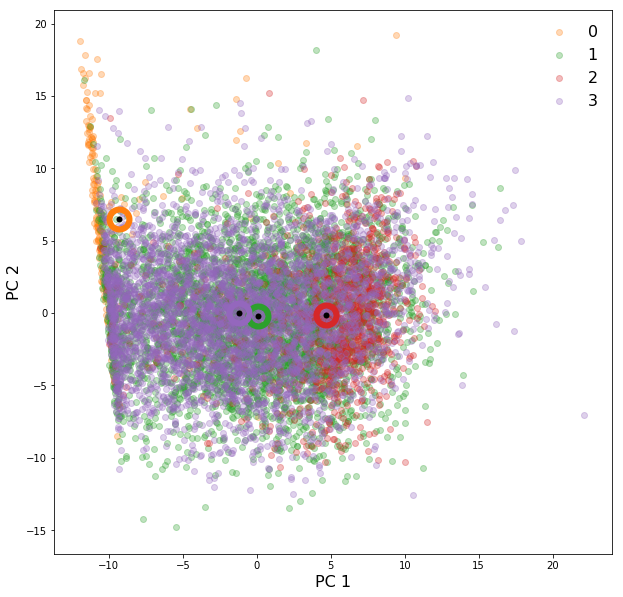

0 208
1 4393
2 1133
3 3843


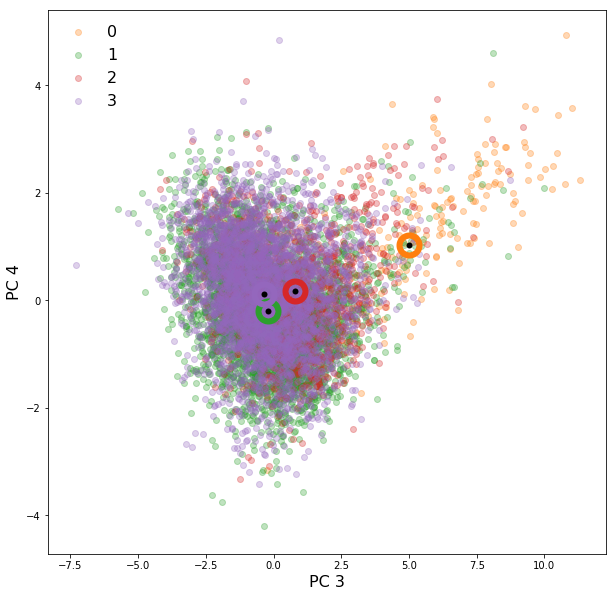

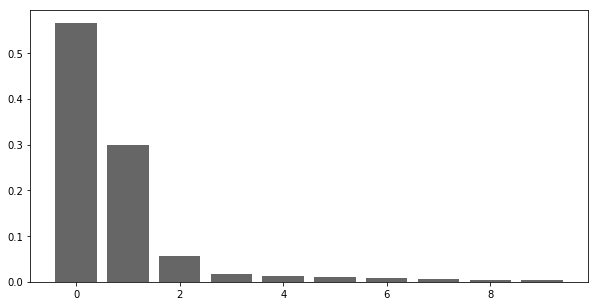

0 432
1 8725
2 2291
3 7693


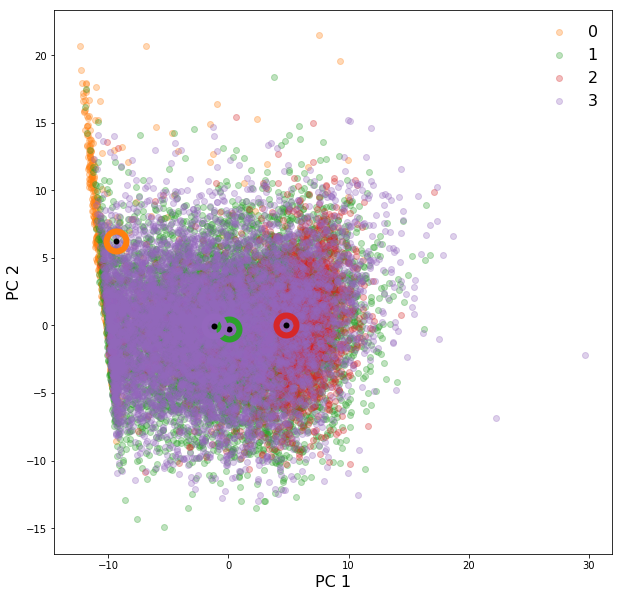

0 432
1 8725
2 2291
3 7693


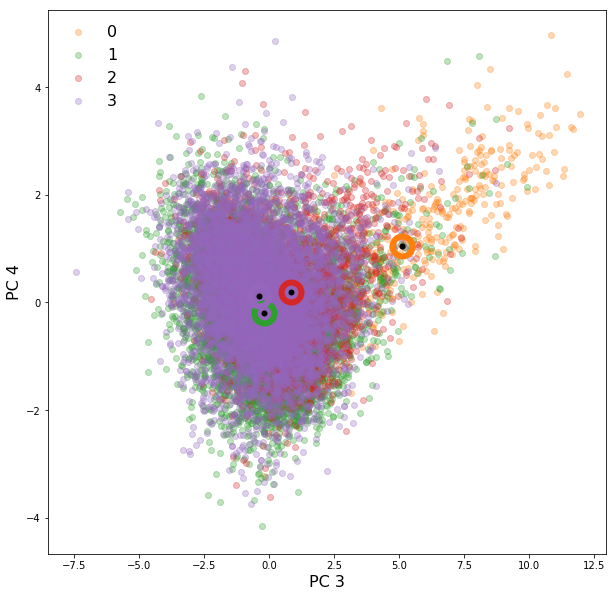

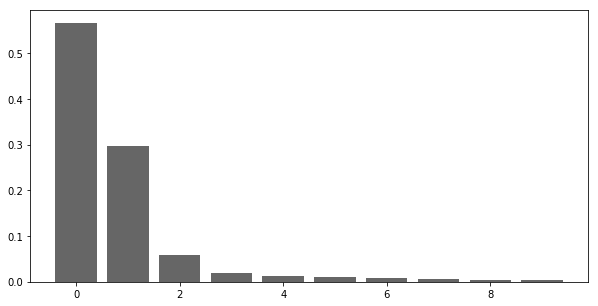

0 648
1 13124
2 3415
3 11469


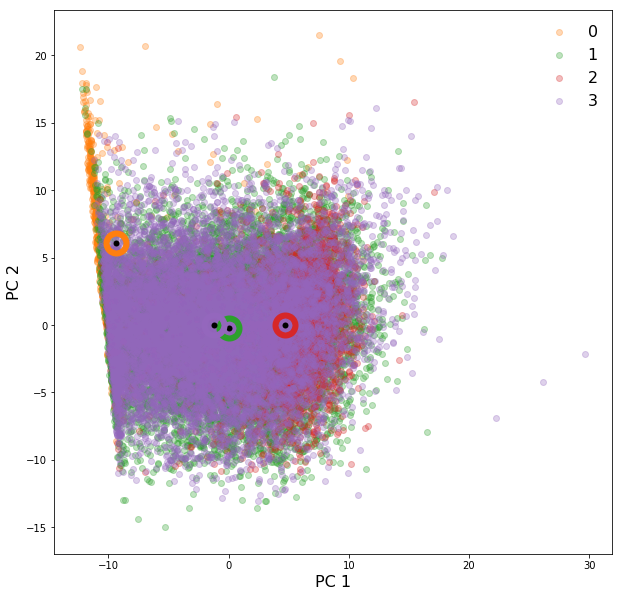

0 648
1 13124
2 3415
3 11469


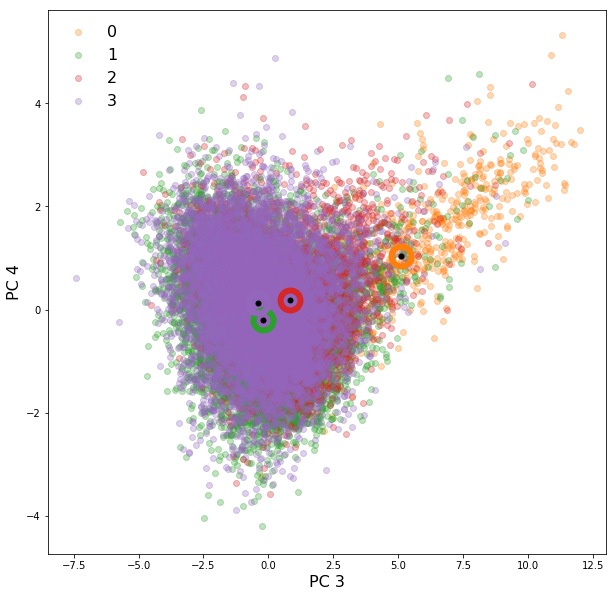

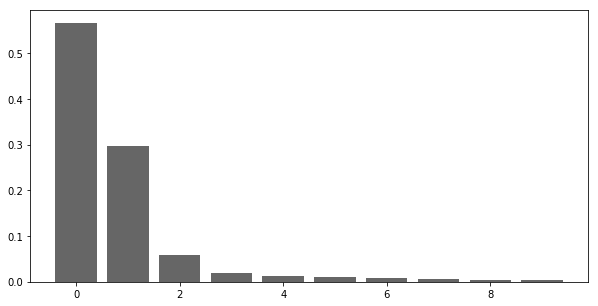

0 837
1 17548
2 4588
3 15234


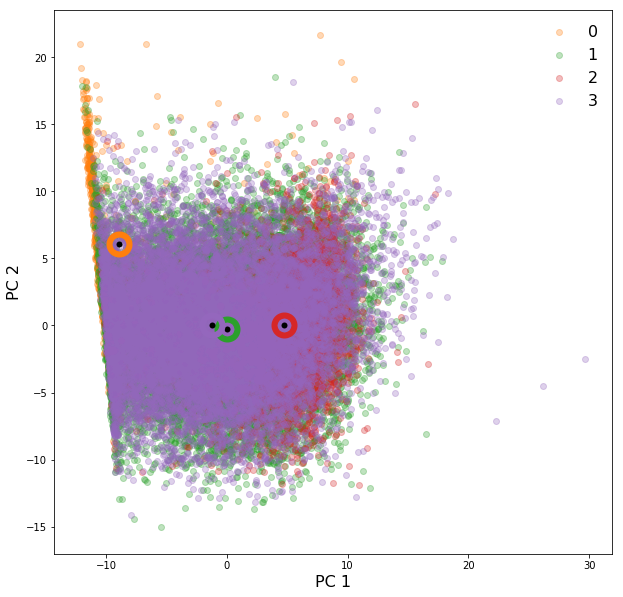

0 837
1 17548
2 4588
3 15234


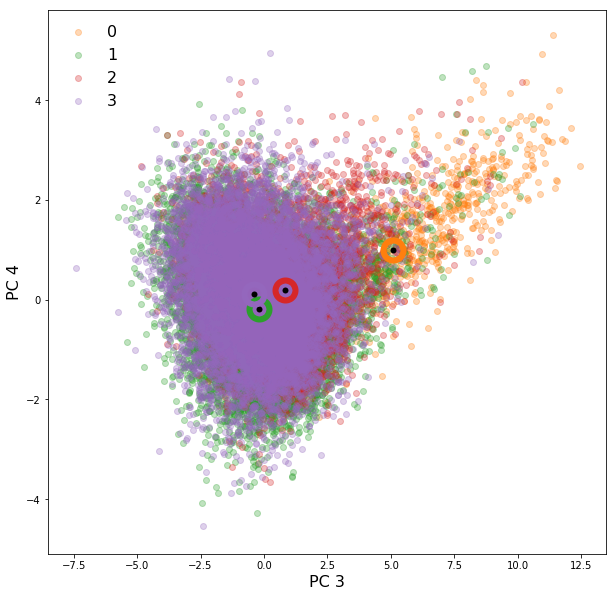

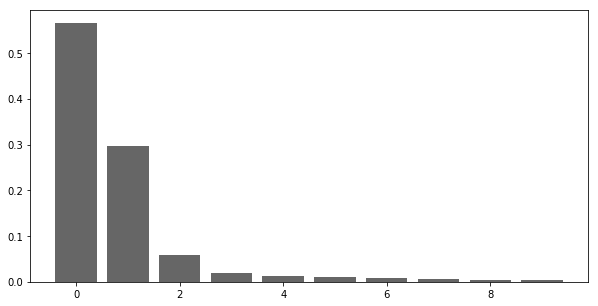

In [184]:
p_c_ids = list(path_dict.keys())

preds = []
infos = []
while len(infos) < 40001:
    print("%d" % len(infos), end="\r")
    c_ids = np.random.choice(p_c_ids, batch_size)
    ps = [path_dict[c_id] for c_id in c_ids]
    
    points, center_vertex_ids = pred.load_orphan_vertex_block_pychg(ps, n_points=n_points)
    p = pred.predict_points(model, points)
    
    for i_c_id in range(len(c_ids)):
        preds.append(p[i_c_id])
        infos.append([c_ids[i_c_id], center_vertex_ids[i_c_id]])
        
    if len(infos) % 10000 == 0:
        pca_plot(np.array(preds), np.array(infos))
        
infos = np.array(infos)
preds = np.array(preds)

0 27
1 337
2 78
3 326


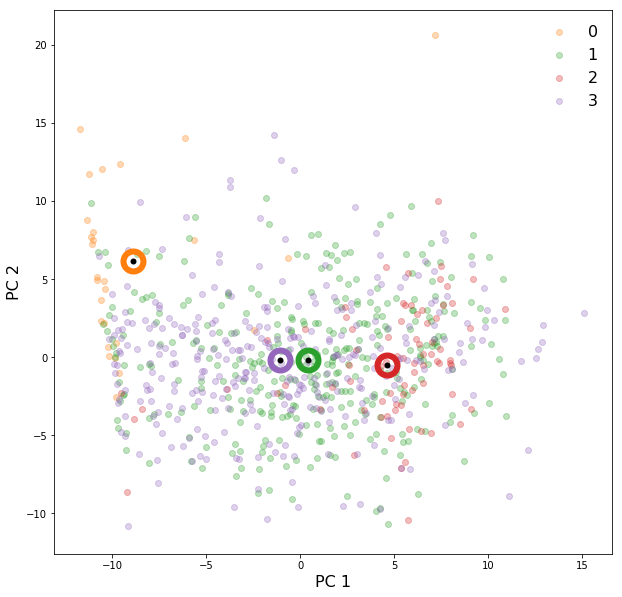

0 27
1 337
2 78
3 326


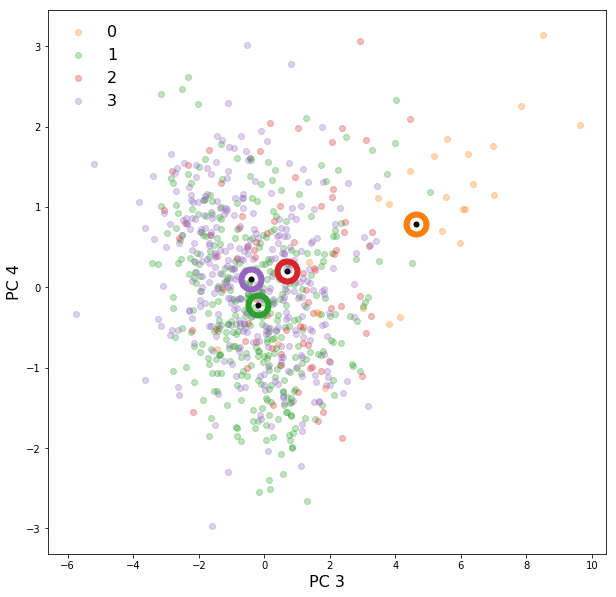

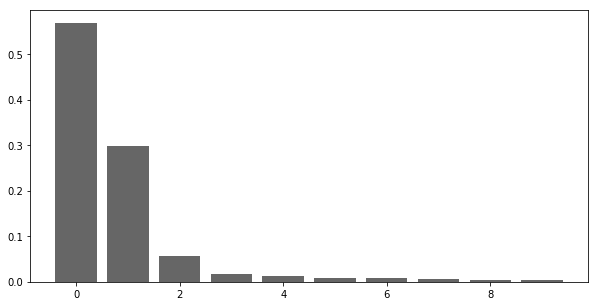

In [197]:
pca_plot(np.array(preds)[::50], np.array(infos)[::50])

In [201]:
point_labels = np.zeros(len(preds), dtype=np.int)
u_cell_ids = np.unique(infos[:, 0])

for u_cell_id in u_cell_ids:
    m = infos[:, 0] == u_cell_id
    point_labels[m] = label_dict[u_cell_id][infos[m, 1]]
    
label_mask = point_labels != -1
point_labels = point_labels[label_mask]

point_labels[point_labels == 3] = 1

In [202]:
preds_n = preds[label_mask].copy()
preds_n /= np.std(preds_n, axis=0)[None]
preds_n -= np.mean(preds_n, axis=0)[None]

preds_n = preds_n[:, ~np.any(np.isnan(preds_n), axis=0)]

/usr/people/svenmd/anaconda3/lib/python3.5/site-packages/ipykernel_launcher.py:2: RuntimeWarning: divide by zero encountered in true_divide
  
/usr/people/svenmd/anaconda3/lib/python3.5/site-packages/ipykernel_launcher.py:2: RuntimeWarning: invalid value encountered in true_divide
  


In [203]:
rfc = ensemble.RandomForestClassifier(n_estimators=100, n_jobs=-1, 
                                      class_weight="balanced_subsample")

accs = []
for i in range(10):
    accs.append(np.mean(model_selection.cross_val_score(rfc, preds_n, 
                                                        point_labels, 
                                                        cv=5)))
    print(accs[-1])
print(np.mean(accs), np.std(accs))
rfc.fit(preds_n, point_labels)

0.8961194336445463
0.896485706635163
0.8957269518408919
0.896485737449378
0.8963810801830535
0.8965643159819459
0.8955176441844074
0.895439038280637
0.8960147284725674
0.8962502860047172
0.8960984922677306 0.0003921152966498405


RandomForestClassifier(bootstrap=True, class_weight='balanced_subsample',
            criterion='gini', max_depth=None, max_features='auto',
            max_leaf_nodes=None, min_impurity_decrease=0.0,
            min_impurity_split=None, min_samples_leaf=1,
            min_samples_split=2, min_weight_fraction_leaf=0.0,
            n_estimators=100, n_jobs=-1, oob_score=False,
            random_state=None, verbose=0, warm_start=False)

In [142]:
rfc.fit(preds_n[:30000], point_labels[:30000])

RandomForestClassifier(bootstrap=True, class_weight='balanced_subsample',
            criterion='gini', max_depth=None, max_features='auto',
            max_leaf_nodes=None, min_impurity_decrease=0.0,
            min_impurity_split=None, min_samples_leaf=1,
            min_samples_split=2, min_weight_fraction_leaf=0.0,
            n_estimators=100, n_jobs=-1, oob_score=False,
            random_state=None, verbose=0, warm_start=False)

In [144]:
cl_labels = rfc.predict(preds_n[30000:])

In [149]:
np.unique(cl_labels, return_counts=True), np.unique(point_labels[30000:], return_counts=True)

((array([0, 1, 2]), array([ 119, 7609,  565])),
 (array([0, 1, 2]), array([ 176, 7110, 1007])))

## Working with full neuron meshes

In [162]:
m = pred.meshmeta.mesh(path_dict[c_ids[1]])

In [163]:
%time v = m.get_local_view(1000)

CPU times: user 0 ns, sys: 0 ns, total: 0 ns
Wall time: 855 µs


In [164]:
v

(array([[209424.      , 100406.226562,  26783.472656],
        [209412.078125, 100334.976562,  26728.251953],
        [209471.59375 , 100320.      ,  26859.488281],
        ...,
        [209825.015625,  99152.765625,  28197.777344],
        [210574.984375,  99161.078125,  27712.34375 ],
        [210096.484375,  99107.796875,  28048.837891]]), 357208)